# Anomaly detection for clickstream data

## Anomaly Detection with DeepAR Timeseries forecasting

We will use variables and dataframes that we stored at 1.EDA step.

In [6]:
%store -r urls css streams

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

We will divide our clikstream events by page. In other words, each page has its own clickstream timesereis. We can consider it as separated product sales in retail store. And we will predict the number of clicks in 10 minutes by referring to the number of visitors. To do this, we use the number of clicks as the target feature and the number of users as the dynamic feature.

Change the data to the format that DeepAR algorithm use. The records in your input files should contain the following fields:

- start—The start timestamp. A string with the format YYYY-MM-DD HH:MM:SS.
- target—An array of floating-point values or integers that represent the time series. Here, we will use clickstream counts in 10 minutes for forecasting value.
- dynamic_feat (optional)—An array of arrays of floating-point values or integers that represents the vector of custom feature time series. Here, we will use the number of visitors in 10 minutes for dynamic features.
- cat (optional)—An array of categorical features that can be used to encode the groups that the record belongs to. We do not use categorical values in this example.

```python
# example:
{"start": "2012-03-01 00:00:00", "target": [24.0, 22.0, 20.0, 17.0, ...], "dynamic_feat": [[13, 14, 8, ...]]}
```

For more information regarding input/outpot format of DeepAR : https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html#deepar-inputoutput

In [22]:
data = []
for index, url in zip(range(len(urls)), urls):
    r = css[css['url'] == url].set_index('timestamp').resample('10T')
    l = {'start' : str(r.nunique().index[0]),
         'target': list(r.sum()['clickstream_id'].values.astype('float')),
         'dynamic_feat': [list(r.nunique()['user_session_id'].values.astype('float'))]
        }
    data.append(l)   

Write the data in above format to json file.

In [9]:
import json

def write_dicts_to_file(path, data):
    with open(path, 'wb') as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode('utf-8'))
            
write_dicts_to_file("train.json", data)

Then, upload this file to the S3.

In [11]:
import sagemaker

sagemaker_session = sagemaker.Session()
s3_bucket = sagemaker.Session().default_bucket()  # replace with an existing bucket if needed
s3_prefix = 'deepar-clickstream'    # prefix used for all data stored within the bucket

role = sagemaker.get_execution_role()             # IAM role to use by SageMaker

train_s3 = sagemaker_session.upload_data(path='train.json', key_prefix=s3_prefix)
train_s3

's3://sagemaker-us-east-1-308961792850/deepar-clickstream/train.json'

In [12]:
import s3fs

s3filesystem = s3fs.S3FileSystem()
with s3filesystem.open(train_s3, 'rb') as fp:
    print(fp.readline().decode("utf-8")[:100] + "...")

{"start": "2012-03-01 00:00:00", "target": [24.0, 22.0, 20.0, 17.0, 15.0, 12.0, 15.0, 10.0, 14.0, 9....


#### SageMaker DeepAR Tranining

Training a model is almost identical to using any other built-in algorithm. We need to define Estimator with algorhtim and hyperparameters and fit the model with the training data that we prepared above.

In [13]:
import datetime 

region = sagemaker_session.boto_region_name

# we use 10 minutes frequency for the time series
freq = datetime.timedelta(minutes=10)

# we predict for 24 hours and use same context length with prediction length.
prediction_length = 24 * 6
context_length = 24 * 6

image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [14]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name='deepar-clickstream'
)

In [15]:
hyperparameters = {
    "time_freq": '10min',
    "epochs": "400",
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length)
}
estimator.set_hyperparameters(**hyperparameters)

Training will take about 20 minutes in c4.2xlarge instance.

In [16]:
%%time
data_channels = {
    "train": train_s3
}

estimator.fit(data_channels, wait=True)

2020-08-11 16:23:31 Starting - Starting the training job...
2020-08-11 16:23:34 Starting - Launching requested ML instances.........
2020-08-11 16:25:17 Starting - Preparing the instances for training......
2020-08-11 16:26:26 Downloading - Downloading input data
2020-08-11 16:26:26 Training - Downloading the training image...
2020-08-11 16:26:48 Training - Training image download completed. Training in progress.Arguments: train
[08/11/2020 16:26:51 INFO 139712694728512] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u

In [17]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, content_type=sagemaker.content_types.CONTENT_TYPE_JSON, **kwargs)
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                num_samples=100, return_samples=False, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_time = ts.index[-1] + datetime.timedelta(minutes=10)
#         prediction_time = 144
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)
    
    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None)

        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles
        }
        
        http_request_data = {
            "instances": [instance],
            "configuration": configuration
        }
        
        return json.dumps(http_request_data).encode('utf-8')
    
    def __decode_response(self, response, freq, prediction_time, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode('utf-8'))['predictions'][0]
        prediction_length = len(next(iter(predictions['quantiles'].values())))
#         prediction_index = pd.DatetimeIndex(start=prediction_time, freq=freq, periods=prediction_length)       
#         print(prediction_time)
#         print(type(prediction_time))
#         print(prediction_length)
#         print(type(prediction_length))
#         print(freq)
#         print(type(freq))
        
        prediction_index = pd.date_range(prediction_time, prediction_time + freq * (prediction_length-1), freq=freq)
#         print(prediction_index)
        
        if return_samples:
            dict_of_samples = {'sample_' + str(i): s for i, s in enumerate(predictions['samples'])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(data={**predictions['quantiles'], **dict_of_samples}, index=prediction_index)

    def set_frequency(self, freq):
        self.freq = freq
        
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]        

def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat        
    return obj

In [19]:
# predictor.delete_endpoint()
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    predictor_cls=DeepARPredictor, 
    wait=False)

In [20]:
infs = pd.Series(data[0]['target'][:-144])
infs.index=pd.date_range(data[0]['start'], datetime.datetime.strptime(data[0]['start'],  '%Y-%m-%d %H:%M:%S') + datetime.timedelta(minutes=10*2015), freq='10T')
infs

2012-03-01 00:00:00    24.0
2012-03-01 00:10:00    22.0
2012-03-01 00:20:00    20.0
2012-03-01 00:30:00    17.0
2012-03-01 00:40:00    15.0
                       ... 
2012-03-14 23:10:00    60.0
2012-03-14 23:20:00    60.0
2012-03-14 23:30:00    38.0
2012-03-14 23:40:00    36.0
2012-03-14 23:50:00    29.0
Freq: 10T, Length: 2016, dtype: float64

In [24]:
prediction = predictor.predict(ts= infs, 
                               dynamic_feat=data[0]['dynamic_feat'],
                               quantiles=[0.10, 0.5, 0.90])

In [25]:
infsf = pd.Series(data[0]['target'])
infsf.index=pd.date_range(data[0]['start'], datetime.datetime.strptime(data[0]['start'],  '%Y-%m-%d %H:%M:%S') + datetime.timedelta(minutes=10*2159), freq='10T')
infsf

2012-03-01 00:00:00    24.0
2012-03-01 00:10:00    22.0
2012-03-01 00:20:00    20.0
2012-03-01 00:30:00    17.0
2012-03-01 00:40:00    15.0
                       ... 
2012-03-15 23:10:00    68.0
2012-03-15 23:20:00    70.0
2012-03-15 23:30:00    50.0
2012-03-15 23:40:00    45.0
2012-03-15 23:50:00    37.0
Freq: 10T, Length: 2160, dtype: float64

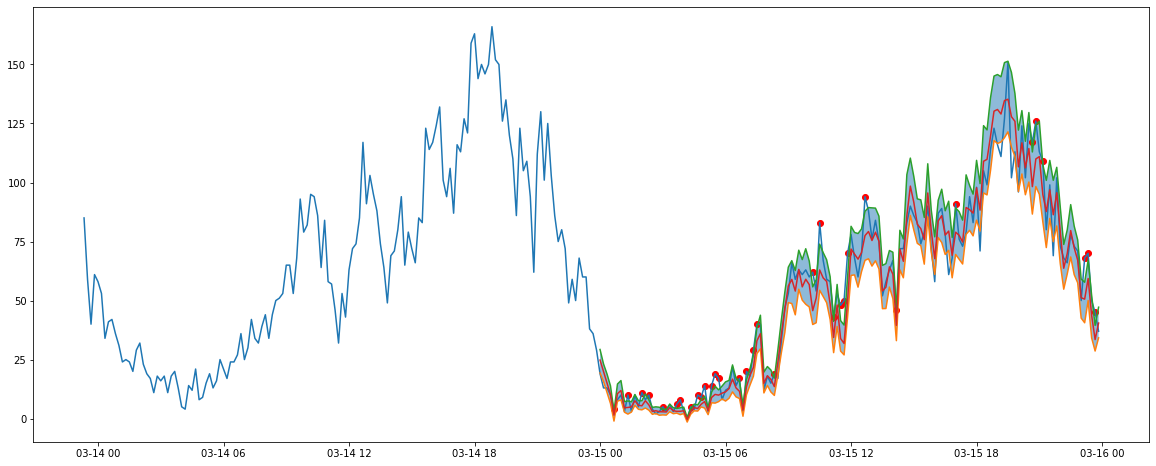

In [58]:
anomalies = infsf['2012-03-15 00:00:00':][infsf['2012-03-15 00:00:00':].values - prediction['0.9'].values > 0]

plt.figure(figsize=(20,8))
plt.plot(infsf['2012-03-13 23:20:00':])
plt.plot(prediction)
plt.fill_between(prediction.index, prediction['0.9'],prediction['0.1'], alpha=0.5)
plt.scatter(anomalies.index, anomalies.values, color='red')

plt.show()

In [54]:
pred2 = prediction.resample('2H').sum()
infsf2 = infsf['2012-03-13 23:20:00':].resample('2H').sum()

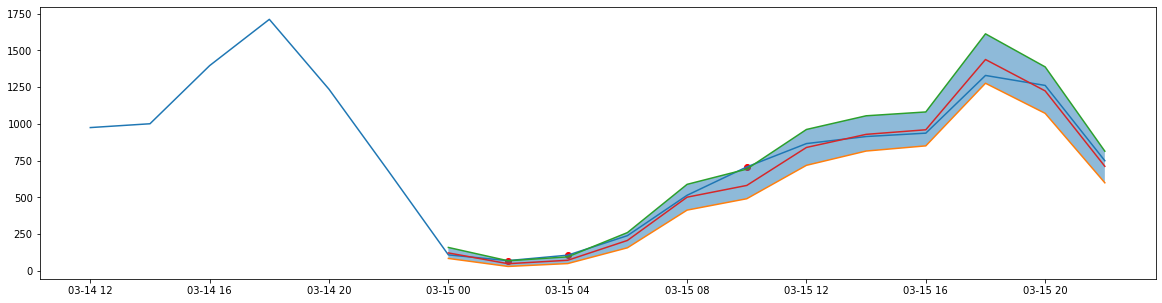

In [57]:
anomalies2 = infsf2['2012-03-15 00:00:00':][infsf2['2012-03-15 00:00:00':].values - pred2['0.9'].values > 0]

plt.figure(figsize=(20,5))
plt.plot(infsf2['2012-03-14 12:00:00':])
plt.plot(pred2)
plt.scatter(anomalies2.index, anomalies2.values, color='red')
plt.fill_between(pred2.index, pred2['0.9'],pred2['0.1'], alpha=0.5)
plt.show()